In [48]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd 
data = pd.read_csv("combined_train_val.csv", header=0)

In [50]:
os.chdir("/content/drive/MyDrive/Thesis/Data/Filled Datasets")

In [51]:
#importing the coaid testdata
coaid_test = pd.read_csv("Preprocessed All/Added Claim News text/textcols_tweets_newstext_added_preprocessed.csv",keep_default_na=False)

In [ ]:
coaid_test

In [53]:
X_test = coaid_test['text']
y_test = coaid_test['label']

In [54]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

In [55]:
# Global parameters
#root folder
#os.chdir("/content/drive/MyDrive/Thesis/")
root_folder='/content/drive/MyDrive/Thesis'
data_folder_name='/Models/Replicated models /Simple models /CNN'
glove_filename='glove.6B.100d.txt'

train_filename='train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
LABEL_COLUM = 'label'

In [56]:
os.path.abspath(glove_filename)


'/content/drive/.shortcut-targets-by-id/1vRVtGuHThSvpkzf0Ydrj3XqxW7eFsqsS/Thesis/Data/Filled Datasets/glove.6B.100d.txt'

In [ ]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec("/content/drive/MyDrive/Thesis/Models/Replicated models /Simple models /CNN/glove.6B.100d.txt", word2vec_output_file)

In [59]:
os.chdir("/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed")

In [60]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


In [61]:
label = data["label"]
text = data["tweet"]

In [62]:
X_train = text
y_train = label

**Vectorization**

In [63]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [64]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = y_train
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = y_test

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 1 / 8558
Numer of samples with no words found: 20 / 126492


oversampling

In [65]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
Xtrain, Ytrain = smote.fit_resample(Xtrain,Ytrain)

In [66]:
print(Xtrain.shape,Xtest.shape)
#dimensions should be (x,100) 

(8960, 100) (126492, 100)


For evaluation metrics: 

In [67]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

**THE SVM MODEL:**



In [ ]:
#running gridsearch on full covid19 data without a testset
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import sys
import logging
import uuid
so = open("data.log - full covid19 -  SVM Smote" +str(uuid.uuid4()), 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
    }

SVM = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1,verbose = 2).fit(Xtrain, Ytrain)
print("train score:", SVM.score(Xtrain, Ytrain))
print("test score:", SVM.score(Xtest, Ytest))
print(" Results from Grid Search" )
print("\n The best estimator across ALL searched params:\n",SVM.best_estimator_)
print("\n The best score across ALL searched params:\n",SVM.best_score_)
print("\n The best parameters across ALL searched params:\n",SVM.best_params_)

In [69]:
#hese parameters were obtained by gridsearch on the lab
from sklearn import svm
svm_model = svm.SVC(C=10, gamma=0.1)

In [18]:
os.chdir("/content/drive/MyDrive/Thesis/Data/Filled Datasets")

In [24]:
#importing the coaid testdata
coaid_test = pd.read_csv("Preprocessed All/Added Claim News text/textcols_tweets_newstext_added_preprocessed.csv",keep_default_na=False)

In [ ]:
coaid_test

In [32]:
X_test = coaid_test['text']
y_test = coaid_test['label']

In [33]:
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = y_test

Numer of samples with no words found: 20 / 126492


In [70]:
svm_model.fit(Xtrain, Ytrain)

SVC(C=10, gamma=0.1)

In [72]:
svm_model.score(Xtrain, Ytrain)

0.9662946428571428

In [71]:
svm_model.score(Xtest, Ytest)

0.5759731840748822

              precision    recall  f1-score   support

           0    0.98731   0.54536   0.70261    120365
           1    0.08804   0.86225   0.15977      6127

    accuracy                        0.56071    126492
   macro avg    0.53767   0.70380   0.43119    126492
weighted avg    0.94375   0.56071   0.67632    126492



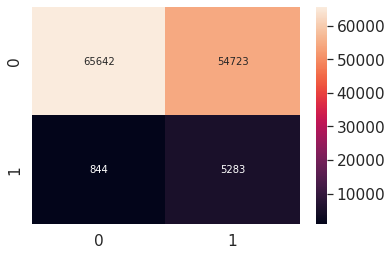

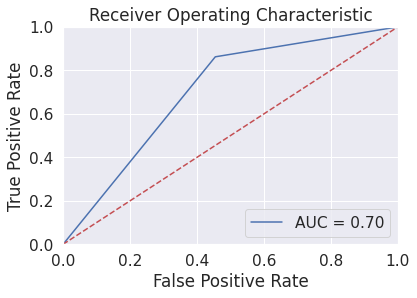

In [36]:
y_pred = svm_model.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=5))
plot_confussion_matrix(Ytest, y_pred)
plot_roc_curve(Ytest, y_pred)